In [1]:
import pandas as pd
import numpy as np
from glob import glob
from scipy import stats
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes
import json
import random
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
from transformer_lens import HookedTransformer
import torch
from jaxtyping import Float, Int
from collections import defaultdict
from sklearn.decomposition import TruncatedSVD
import itertools
import torch.nn.functional as F
import math
import seaborn as sns

## Setup

In [2]:
def get_device_str() -> str:
    if torch.backends.mps.is_available():
        return "mps"
    else:
        return "cuda" if torch.cuda.is_available() else "cpu"


def comp_js_divergence(
    p_logit: Float[torch.Tensor, "*batch vocab"],
    q_logit: Float[torch.Tensor, "*batch vocab"],
) -> Float[torch.Tensor, "*batch"]:
    p_logprob = torch.log_softmax(p_logit, dim=-1)
    q_logprob = torch.log_softmax(q_logit, dim=-1)
    p = p_logprob.exp()
    q = q_logprob.exp()

    # convert to log2
    p_logprob *= math.log2(math.e)
    q_logprob *= math.log2(math.e)

    m = 0.5 * (p + q)
    m_logprob = m.log2()

    p_kl_div = (p * (p_logprob - m_logprob)).sum(-1)
    q_kl_div = (q * (q_logprob - m_logprob)).sum(-1)

    assert p_kl_div.isfinite().all()
    assert q_kl_div.isfinite().all()
    return (p_kl_div + q_kl_div) / 2


def find_js_dist_blowup(
    js_dists: List[float],
    slope_threshold: float = 1.25,
    min_js_distance: float = 0.1,
    min_slope_threshold: float = 0.02,
) -> int:
    steps = list(range(len(js_dists)))

    slopes = []
    for i in range(1, len(steps)):
        dy = js_dists[i] - js_dists[i - 1]
        dx = steps[i] - steps[i - 1]
        slopes.append(dy / dx if dx != 0 else 0)

    # Pad the beginning of slopes list to match the length of steps
    slopes = [slopes[0]] + slopes

    for i in range(1, len(steps)):
        current_slope = slopes[i]
        prev_slope = slopes[i - 1]

        # print(f"step={i}, {current_slope=} {prev_slope=}, {slope_threshold * max(prev_slope, 1e-6)}")

        # Check if we're in an increasing trend and above minimum JS distance
        if (
            current_slope > (slope_threshold * max(prev_slope, 1e-6))
            or current_slope >= min_slope_threshold
        ) and js_dists[i] >= min_js_distance:
            return i

    return len(steps) - 1


def find_plateau_length_js(
    js_dists: List[float], threshold: float = 5e-03, window_size: int = 5
) -> int:

    def calculate_slope(y_values, x_values):
        slope, _, _, _, _ = stats.linregress(x_values, y_values)
        return slope

    for i in range(len(js_dists) - window_size + 1):
        window = js_dists[i : i + window_size]
        x_values = list(range(window_size))
        slope = calculate_slope(window, x_values)

        if abs(slope) > threshold:
            return i

    return len(js_dists) - 1


def load_jsonl(file_path):
    data = []
    with open(file_path, "r") as file:
        for line in file:
            # Parse each line as a JSON object
            json_object = json.loads(line.strip())
            data.append(json_object)
    return data


def get_feature_dir(sae, feature_id, feature_act, norm=False):
    feature_acts = torch.zeros(sae.W_enc.shape[1])

    # Activate the specified feature
    feature_acts[:] = 0
    feature_acts[feature_id] = feature_act

    # Decode back to the residual stream space
    perturbed_act = sae.decode(feature_acts)

    if norm:
        perturbed_act /= torch.norm(perturbed_act)

    return perturbed_act

In [3]:
model = HookedTransformer.from_pretrained("gpt2")
device = get_device_str()

print(device)

Loaded pretrained model gpt2 into HookedTransformer
cuda


In [4]:
perturbation_layer = "blocks.0.hook_resid_pre"
saes, sparsities = get_gpt2_res_jb_saes(perturbation_layer)
sae = saes[perturbation_layer].cpu()
feature_sparsities = 10 ** sparsities[perturbation_layer].cpu()

sae.eval()

100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


SAE(
  (activation_fn): ReLU()
  (hook_sae_input): HookPoint()
  (hook_sae_acts_pre): HookPoint()
  (hook_sae_acts_post): HookPoint()
  (hook_sae_output): HookPoint()
  (hook_sae_recons): HookPoint()
  (hook_sae_error): HookPoint()
)

In [5]:
metadata, activations = [], []

for path in glob("observations/metadata*"):
    metadata.extend(load_jsonl(path))

for path in glob("observations/acts*"):
    activations.append(np.load(path))

activations = np.concatenate(activations)

In [6]:
len(metadata), activations.shape

(5000, (5000, 100, 768))

## Feature Dynamics

In [75]:
feature_activations = []
js_dists = []

example_idx = 0

for i, s in enumerate(metadata[example_idx]["steps_metadata"]):
    active_feature_ids = s["active_feature_ids"]
    active_feature_acts = s["active_feature_acts"]
    feature_acts = torch.zeros(sae.W_enc.shape[1])
    feature_acts[active_feature_ids] = torch.tensor(active_feature_acts)
    feature_activations.append(feature_acts)
    js_dists.append(s["js_dist"])

feature_activations = torch.stack(feature_activations)

### Gradients and acceleration

In [46]:
row_indices = np.arange(feature_activations.shape[0])[:, np.newaxis]
top_features_per_step = np.argsort(feature_activations)[:, -5:]
top_features_acts = feature_activations[row_indices, top_features_per_step]

gradients = np.gradient(top_features_acts, axis=0)
accelerations = np.gradient(gradients, axis=0)

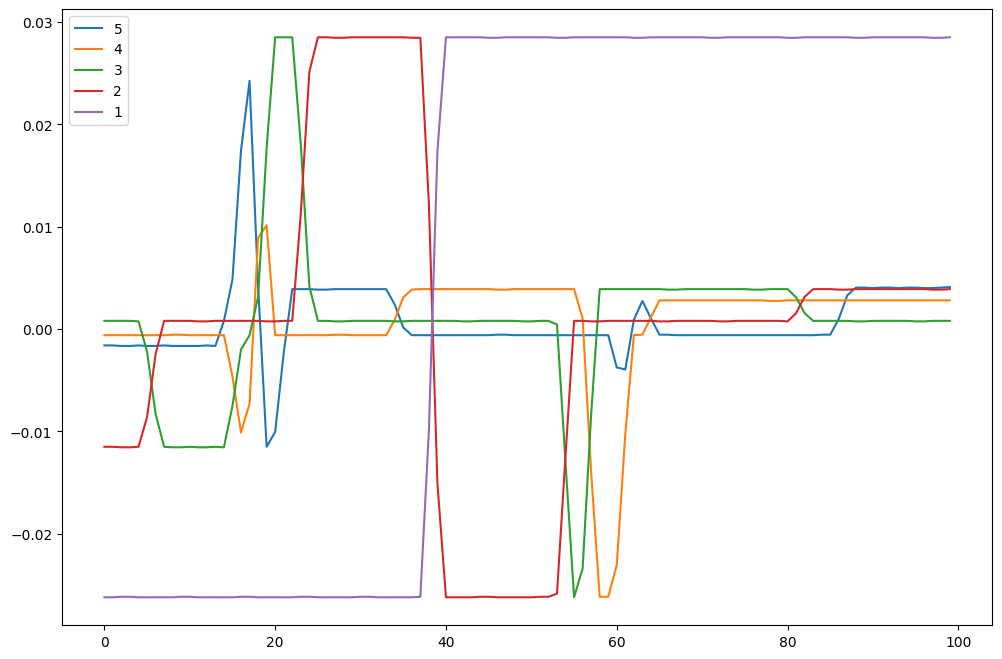

In [47]:
plt.figure(figsize=(12, 8))

for feature_idx in range(5):
    plt.plot(gradients[:, feature_idx], label=5 - feature_idx)

plt.legend()
plt.show()

### Heatmap of feature activations

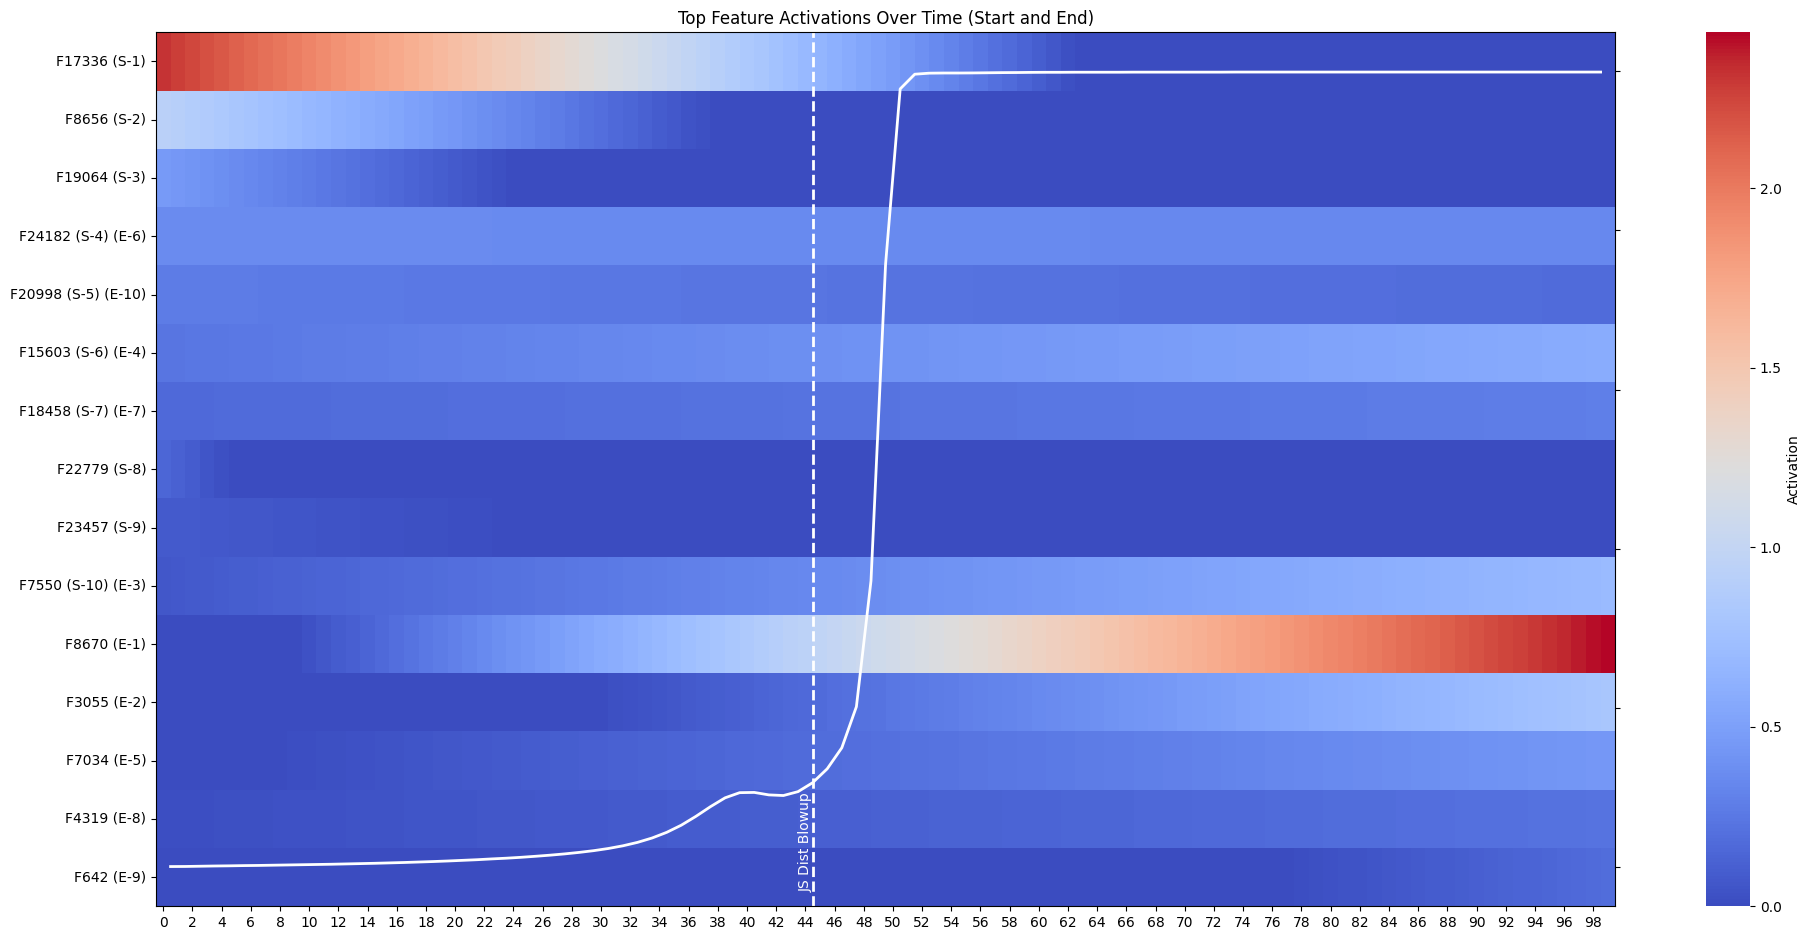

In [77]:
# Assuming feature_activations is a PyTorch tensor
feature_acts_np = feature_activations.numpy()  # Convert to numpy if it's not already

# Identify top features from start and end
n_top = 10
start_top_features = np.argsort(feature_acts_np[0])[-n_top:][::-1]
end_top_features = np.argsort(feature_acts_np[-1])[-n_top:][::-1]

# Assume js_blowup_step is the time step where JS distance starts increasing rapidly
js_blowup_step = find_js_dist_blowup(js_dists)  # Replace with your actual step

# Combine and get unique features
combined_features = np.unique(np.concatenate([start_top_features, end_top_features]))

# Create labels for y-axis
y_labels = []

feature_ranks = []

for feat in combined_features:
    start_rank = np.where(start_top_features == feat)[0]
    end_rank = np.where(end_top_features == feat)[0]
    feature_rank = 0

    label = f"F{feat}"
    if len(start_rank) > 0:
        label += f" (S-{start_rank[0]+1})"
        feature_rank += start_rank[0]
    else:
        feature_rank += n_top

    if len(end_rank) > 0:
        label += f" (E-{end_rank[0]+1})"
        if len(start_rank) == 0:
            feature_rank += 10 + end_rank[0]

    y_labels.append(label)
    feature_ranks.append(feature_rank)


sorted_feature_ranks = np.argsort(feature_ranks)
sorted_y_labels = [y_labels[idx] for idx in sorted_feature_ranks]

# Create heatmap
fig, ax = plt.subplots(figsize=(20, len(combined_features) / 2 + 2))
sns.heatmap(
    feature_acts_np[:, combined_features[sorted_feature_ranks]].T,
    cmap="coolwarm",
    cbar_kws={"label": "Activation"},
    yticklabels=sorted_y_labels,
    ax=ax,
)

# Add vertical line for JS distance blowup
ax.axvline(x=js_blowup_step, color="white", linestyle="--", linewidth=2)

# Add text annotation for the JS blowup line
ax.text(
    js_blowup_step,
    len(combined_features) - 0.25,
    "JS Dist Blowup",
    rotation=90,
    va="bottom",
    ha="right",
    color="white",
    fontweight="normal",
)


# Assuming js_distances is your array of JS distances over time
ax2 = ax.twinx()
ax2.plot(js_dists, color="white", linewidth=2)
ax2.set_ylabel("JS Distance", color="white")
ax2.tick_params(axis="y", labelcolor="white")

plt.title("Top Feature Activations Over Time (Start and End)")
plt.xlabel("Time Steps")
plt.ylabel("Feature ID (Start Rank, End Rank)")
plt.tight_layout()
plt.show()

### Entropy analysis of feature activations

In [78]:
from scipy.stats import entropy

In [79]:
sae_recon_errors = []

for i, fa in enumerate(feature_activations):
    act = torch.tensor(activations[example_idx][i])
    act_recon = sae.decode(sae.encode(act))
    recon_error = (act - act_recon).abs().sum()
    sae_recon_errors.append(recon_error.item())

In [80]:
js_blowup_step = find_js_dist_blowup(js_dists)

In [94]:
js_plateau_len = find_plateau_length_js(js_dists)

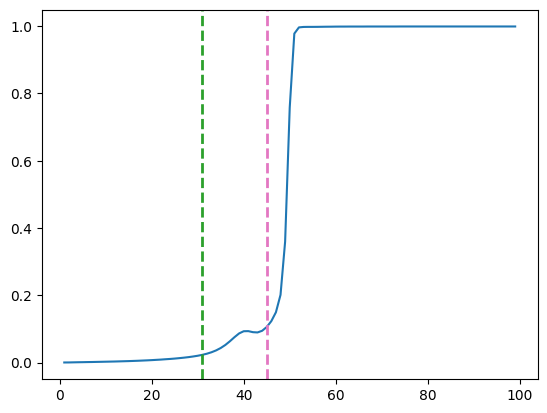

In [96]:
plt.plot(js_dists)
plt.axvline(x=js_plateau_len, color="tab:green", linestyle="--", linewidth=2)
plt.axvline(x=js_blowup_step, color="tab:pink", linestyle="--", linewidth=2)

In [59]:
feature_acts_distr = F.softmax(feature_activations, dim=-1)
entropies = [entropy(f, base=2) for f in feature_acts_distr]

In [60]:
corr, p_value = stats.spearmanr(entropies, sae_recon_errors)
print(corr, p_value)

0.5837623762376236 1.8343523450261075e-10


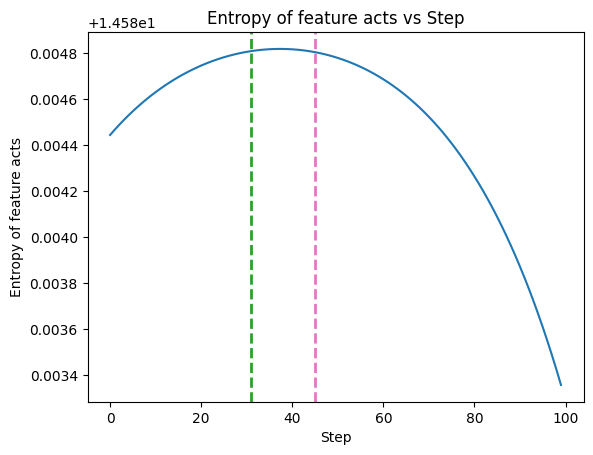

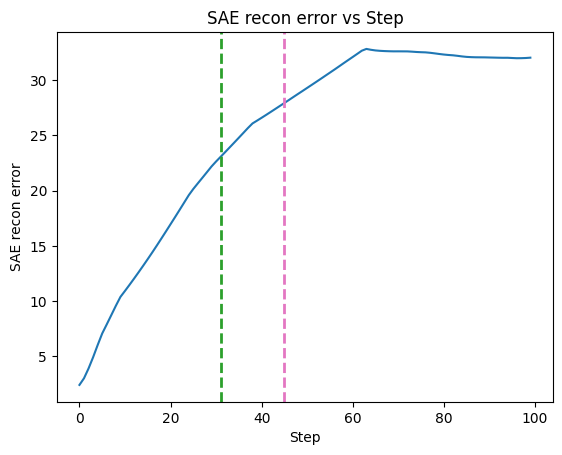

In [98]:
plt.plot(entropies)
plt.title("Entropy of feature acts vs Step")
plt.xlabel("Step")
plt.ylabel("Entropy of feature acts")
plt.axvline(x=js_plateau_len, color="tab:green", linestyle="--", linewidth=2)
plt.axvline(x=js_blowup_step, color="tab:pink", linestyle="--", linewidth=2)
plt.show()


plt.plot(sae_recon_errors)
plt.title("SAE recon error vs Step")
plt.xlabel("Step")
plt.ylabel("SAE recon error")
plt.axvline(x=js_plateau_len, color="tab:green", linestyle="--", linewidth=2)
plt.axvline(x=js_blowup_step, color="tab:pink", linestyle="--", linewidth=2)
plt.show()

### SAE reconstruction error correlation with blowup/plateau

In [174]:
js_dists = []
js_blowups = []
js_plateaus = []
sae_recon_errors = []
max_sae_recon_errors = []

for i, (m, acts) in enumerate(zip(metadata[:100], activations[:100])):
    act_recon = sae.decode(sae.encode(torch.tensor(acts)))
    recon_error = torch.tensor(acts) - act_recon
    sae_recon_errors.append(recon_error.abs().sum(dim=-1).detach().numpy())

    max_sae_recon_errors.append(recon_error.abs().sum(dim=-1).max(dim=-1)[1].item())
    m_js_dists = [
        0 if pd.isna(s["js_dist"]) else s["js_dist"] for s in m["steps_metadata"]
    ]
    js_dists.append(m_js_dists)
    js_blowup_step = find_js_dist_blowup(m_js_dists)
    js_plateau_len = find_plateau_length_js(m_js_dists)
    js_blowups.append(js_blowup_step)
    js_plateaus.append(js_plateau_len)

    if i % 50 == 0:
        print(i)

0


50


In [167]:
js_dists_flat = [v for j in js_dists for v in j]
sae_recon_errors_flat = [v for j in sae_recon_errors for v in j]

In [163]:
corr, p_value = stats.spearmanr(sae_recon_errors_flat, js_dists_flat)
print(f"Corr={corr:.4f}\nP-Value: {p_value:.4f}")

Corr=0.1405
P-Value: 0.0000


In [178]:
corr, p_value = stats.spearmanr(max_sae_recon_errors, js_blowups)
print(f"Corr={corr:.4f}\nP-Value: {p_value:.4f}")

Corr=0.1340
P-Value: 0.1839


## Modelling

In [370]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from scipy.stats import entropy
import cupy as cp

In [354]:
def get_feature_activations(steps):
    feature_activations = []
    for i, s in enumerate(steps):
        active_feature_ids = s["active_feature_ids"]
        active_feature_acts = s["active_feature_acts"]
        feature_acts = torch.zeros(sae.W_enc.shape[1])
        feature_acts[active_feature_ids] = torch.tensor(active_feature_acts)
        feature_activations.append(feature_acts)
    return torch.stack(feature_activations)


def compute_stats_in_buckets(data, n_buckets=5):
    # Calculate the size of each bucket
    bucket_size = data.shape[0] // n_buckets

    # Initialize arrays to store the computed statistics
    means = np.zeros((n_buckets, data.shape[1]))
    stds = np.zeros((n_buckets, data.shape[1]))
    medians = np.zeros((n_buckets, data.shape[1]))
    max_vals = np.zeros((n_buckets, data.shape[1]))
    min_vals = np.zeros((n_buckets, data.shape[1]))
    skewness = np.zeros((n_buckets, data.shape[1]))
    kurtosis = np.zeros((n_buckets, data.shape[1]))

    # Compute statistics for each bucket
    for i in range(n_buckets):
        start_idx = i * bucket_size
        end_idx = (i + 1) * bucket_size if i < n_buckets - 1 else data.shape[0]

        bucket_data = data[start_idx:end_idx, :]

        means[i] = np.mean(bucket_data, axis=0)
        stds[i] = np.std(bucket_data, axis=0)
        medians[i] = np.median(bucket_data, axis=0)
        # max_vals[i] = np.max(bucket_data, axis=0)
        # min_vals[i] = np.min(bucket_data, axis=0)

        # # Use scipy.stats for skewness and kurtosis
        # skewness[i] = np.nan_to_num(stats.skew(bucket_data, axis=0), nan=0.0)
        # kurtosis[i] = np.nan_to_num(stats.kurtosis(bucket_data, axis=0), nan=0.0)

    # Compute additional features
    # ranges = max_vals - min_vals

    # Combine all features
    features = np.hstack([means, stds, medians]).reshape(-1)
    return features

In [355]:
feature_names = []
features = []
labels = []

# grad_feat_names = [
#     f"grad_{fname}_top_{t}_bucket_{b}"
#     for fname in ["mean", "std"]
#     for b in range(1, 6)
#     for t in range(1, 6)
# ]
# feature_names.append(grad_feat_names)

n_examples = 5000
idxs = random.sample(range(len(metadata)), n_examples)

for i, idx in enumerate(idxs):
    steps = metadata[idx]["steps_metadata"]
    js_dists = [s["js_dist"] for s in steps]
    js_blowup_step = find_js_dist_blowup(js_dists)
    sensitivity = 1 - js_blowup_step / len(js_dists)
    labels.append(sensitivity)

    feature_activations = get_feature_activations(steps)

    row_indices = np.arange(feature_activations.shape[0])[:, np.newaxis]
    top_features_per_step = np.argsort(feature_activations)[:, -3:].flip(dims=(1,))
    top_features_acts = feature_activations[row_indices, top_features_per_step]

    gradients = np.gradient(top_features_acts, axis=0)
    grad_feats = compute_stats_in_buckets(gradients, n_buckets=5)

    accelerations = np.gradient(gradients, axis=0)
    acc_feats = compute_stats_in_buckets(accelerations, n_buckets=5)

    pert_feats = np.concatenate([grad_feats, acc_feats])
    features.append(pert_feats)

    if i % 500 == 0:
        print(f"Step {i}")

Step 0
Step 500
Step 1000
Step 1500
Step 2000
Step 2500
Step 3000
Step 3500
Step 4000
Step 4500


In [356]:
X = np.vstack(features)
y = np.array(labels)
print(X.shape, len(y))

(5000, 90) 5000


In [357]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=444222
)

print(X_train.shape, X_test.shape)

(4500, 90) (500, 90)


In [358]:
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(estimator=xgb.XGBRegressor(), threshold="median")
X_selected = selector.fit_transform(X_train, y_train)
X_selected.shape

(4500, 45)

In [359]:
# Convert your data to GPU
X_train_gpu = cp.array(X_selected)
y_train_gpu = cp.array(y_train)

In [363]:
reg_model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    min_child_weight=1,
    # subsample=0.5,
    # colsample_bytree=0.8,
    reg_alpha=0.5,
    # reg_lambda=0.5,
    # gamma=0.1,
    random_state=42,
    device="cuda",
)

In [364]:
reg_model.fit(X_train_gpu, y_train_gpu)

y_pred = reg_model.predict(X_train_gpu)
mse = mean_squared_error(y_train, y_pred, multioutput="raw_values")[0]
r2 = r2_score(y_train, y_pred, multioutput="raw_values")[0]

print(f"Train MSE: {mse:.4f}")
print(f"Train R-squared: {r2:.4f}")

Train MSE: 0.0032
Train R-squared: 0.7254


In [365]:
X_test_selected = selector.transform(X_test)
X_test_gpu = cp.array(X_test_selected)
y_pred = reg_model.predict(X_test_gpu)

mse = mean_squared_error(y_test, y_pred, multioutput="raw_values")[0]
r2 = r2_score(y_test, y_pred, multioutput="raw_values")[0]

print(f"MSE: {mse:.4f}")
print(f"R-squared: {r2:.4f}")

MSE: 0.0085
R-squared: 0.3486


In [321]:
# # Scale the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # # Set up GridSearchCV
# # param_grid = {
# #     'C': [0.1, 1, 10, 100],
# #     'epsilon': [0.01, 0.1, 0.5, 1],
# #     'kernel': ['rbf', 'linear']
# # }

# params = {'C': 0.1, 'epsilon': 0.01, 'kernel': 'rbf'}
# svm_model = SVR(**params)
# # grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# # Fit the model
# svm_model.fit(X_train_scaled, y_train)

# # Get the best model
# # best_svm_model = grid_search.best_estimator_

# # Make predictions
# y_pred = svm_model.predict(X_test_scaled)

# # Calculate metrics
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# # print(f"Best parameters: {grid_search.best_params_}")
# print(f"MSE: {mse:.4f}")
# print(f"R-squared: {r2:.4f}")